In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 331M/331M [00:15<00:00, 23.9MB/s]
100% 331M/331M [00:15<00:00, 21.9MB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

In [4]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [6]:
import os

In [7]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

# **1-Import Modules**

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
from PIL import Image

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras import initializers, layers
import keras.backend as K
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization

# **2-Load the Dataset**

In [13]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = img_path, age, gender
df.head()

,image,age,gender
0,23_1_3_20170119164552438.jpg.chip.jpg,23,1
1,27_0_1_20170117125937977.jpg.chip.jpg,27,0
2,26_1_2_20170116184050204.jpg.chip.jpg,26,1
3,22_1_3_20170104222547654.jpg.chip.jpg,22,1
4,28_0_2_20170116191850216.jpg.chip.jpg,28,0


In [17]:
gender_dict = {0:'Male', 1:'Female'}

In [28]:
# Prepend the folder path to the 'image' column
df['image'] = df['image'].apply(lambda x: os.path.join(folder_path, x))

In [ ]:
# Verify the updated paths
print(df['image'].head())  # Check if paths are correct

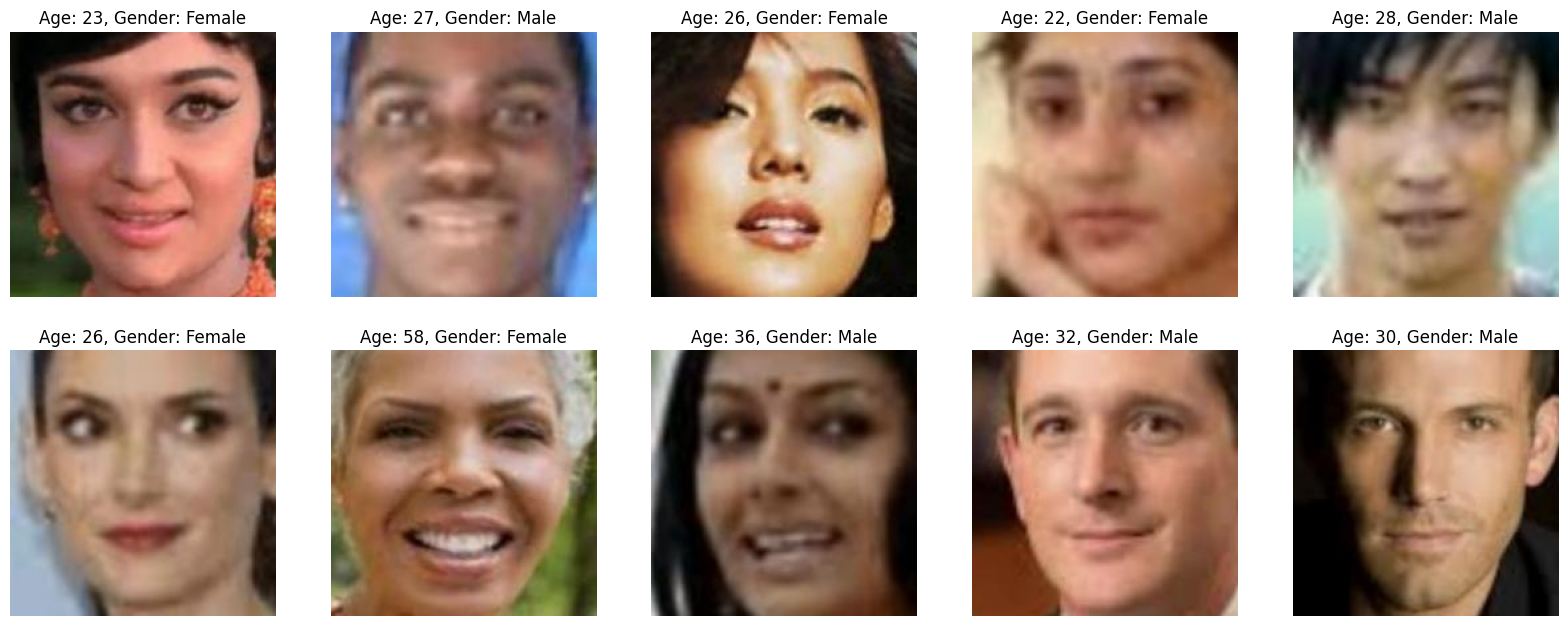

In [29]:
plt.figure(figsize=(20, 20))

# Select first 10 rows for visualization
files = df.iloc[0:10, :]

for index, row in files.iterrows():
    try:
        # Load and plot the image
        plt.subplot(5, 5, index + 1)
        img = load_img(row['image'])
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Age: {row['age']}, Gender: {gender_dict[row['gender']]}")
    except FileNotFoundError:
        print(f"File not found: {row['image']}")

plt.show()

# **3-Data Analysis**

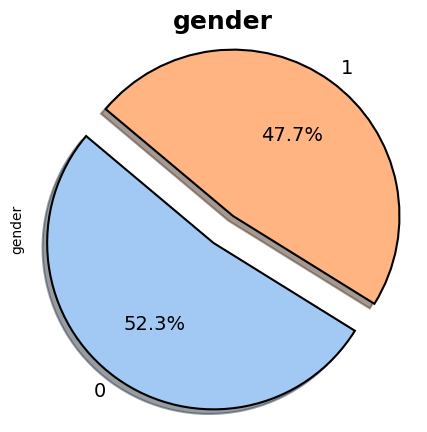

In [30]:
def plot_data(name, data):
    plt.figure(figsize=(5, 5))
    palette_color = sns.color_palette('pastel')
    explode = [0.1 for _ in range(data.nunique())]

    target_counts = df.groupby(name)[name].count()

    target_counts.plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,
    startangle=140,
    textprops={'fontsize': 14},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
    )

    plt.title(name, fontsize=18, weight='bold')
    plt.axis('equal')
    plt.show()


plot_data('gender', df['gender'])

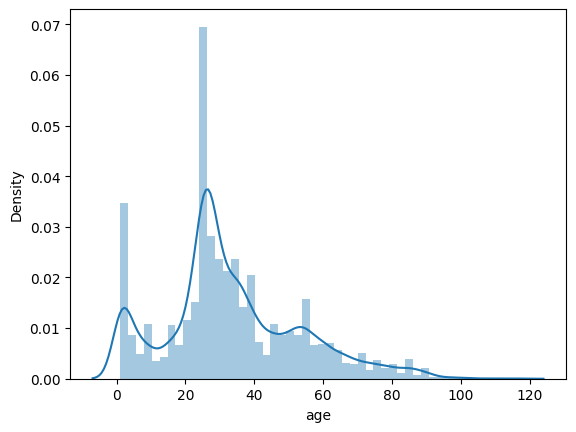

In [31]:
sns.distplot(df['age']);

# **4-Feature Extraction**

In [32]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [33]:
X = extract_features(df['image'])
X = X/255.0

  0%|          | 0/23708 [00:00<?, ?it/s]

In [34]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

# **5-Model Creation**

In [35]:
inputs = Input((128, 128, 1))

conv_1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv_1') (inputs)
batch_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(32, 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal') (batch_1)
maxp_1 = MaxPooling2D() (conv_2)
dropout_1 = Dropout(0.25) (maxp_1)

flatten = Flatten() (dropout_1)

# fully connected layers
dense_1 = Dense(128, activation = 'relu', kernel_initializer = 'he_normal') (flatten)
dense_2 = Dense(128, activation = 'relu', kernel_initializer = 'he_normal') (flatten)

batch_2 = BatchNormalization() (dense_1)
batch_3 = BatchNormalization() (dense_2)

dropout_2 = Dropout(0.5) (batch_2)
dropout_3 = Dropout(0.5) (batch_3)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_2)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_3)


model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

## **Fit the model**

In [36]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=15, validation_split=0.05)

Epoch 1/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 145s 177ms/step - age_out_loss: 21.5785 - age_out_mae: 21.5785 - gender_out_accuracy: 0.7485 - gender_out_loss: 0.5469 - loss: 22.1254 - val_age_out_loss: 12.8536 - val_age_out_mae: 12.6033 - val_gender_out_accuracy: 0.8145 - val_gender_out_loss: 0.3771 - val_loss: 12.9859
Epoch 2/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 109s 155ms/step - age_out_loss: 10.7704 - age_out_mae: 10.7704 - gender_out_accuracy: 0.8487 - gender_out_loss: 0.3509 - loss: 11.1213 - val_age_out_loss: 9.5801 - val_age_out_mae: 9.3942 - val_gender_out_accuracy: 0.8609 - val_gender_out_loss: 0.3217 - val_loss: 9.7222
Epoch 3/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 144s 158ms/step - age_out_loss: 9.5437 - age_out_mae: 9.5437 - gender_out_accuracy: 0.8597 - gender_out_loss: 0.3260 - loss: 9.8696 - val_age_out_loss: 8.7024 - val_age_out_mae: 8.6543 - val_gender_out_accuracy: 0.8668 - val_gender_out_loss: 0.3030 - val_loss: 8.9638
Epoch 4/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 158ms/step - age_out_l

In [38]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_1 (Conv2D)           │ (None, 120, 120, 256)  │         20,992 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 120, 120, 256)  │          1,024 │ conv_1[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 120, 120, 32)   │        204,832 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 60, 60, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 60, 60, 32)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 115200)         │              0 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │     14,745,728 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │     14,745,728 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128)            │            512 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_out (Dense)        │ (None, 1)              │            129 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_out (Dense)           │ (None, 1)              │            129 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 89,156,712 (340.11 MB)

 Trainable params: 29,718,562 (113.37 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 59,437,126 (226.73 MB)

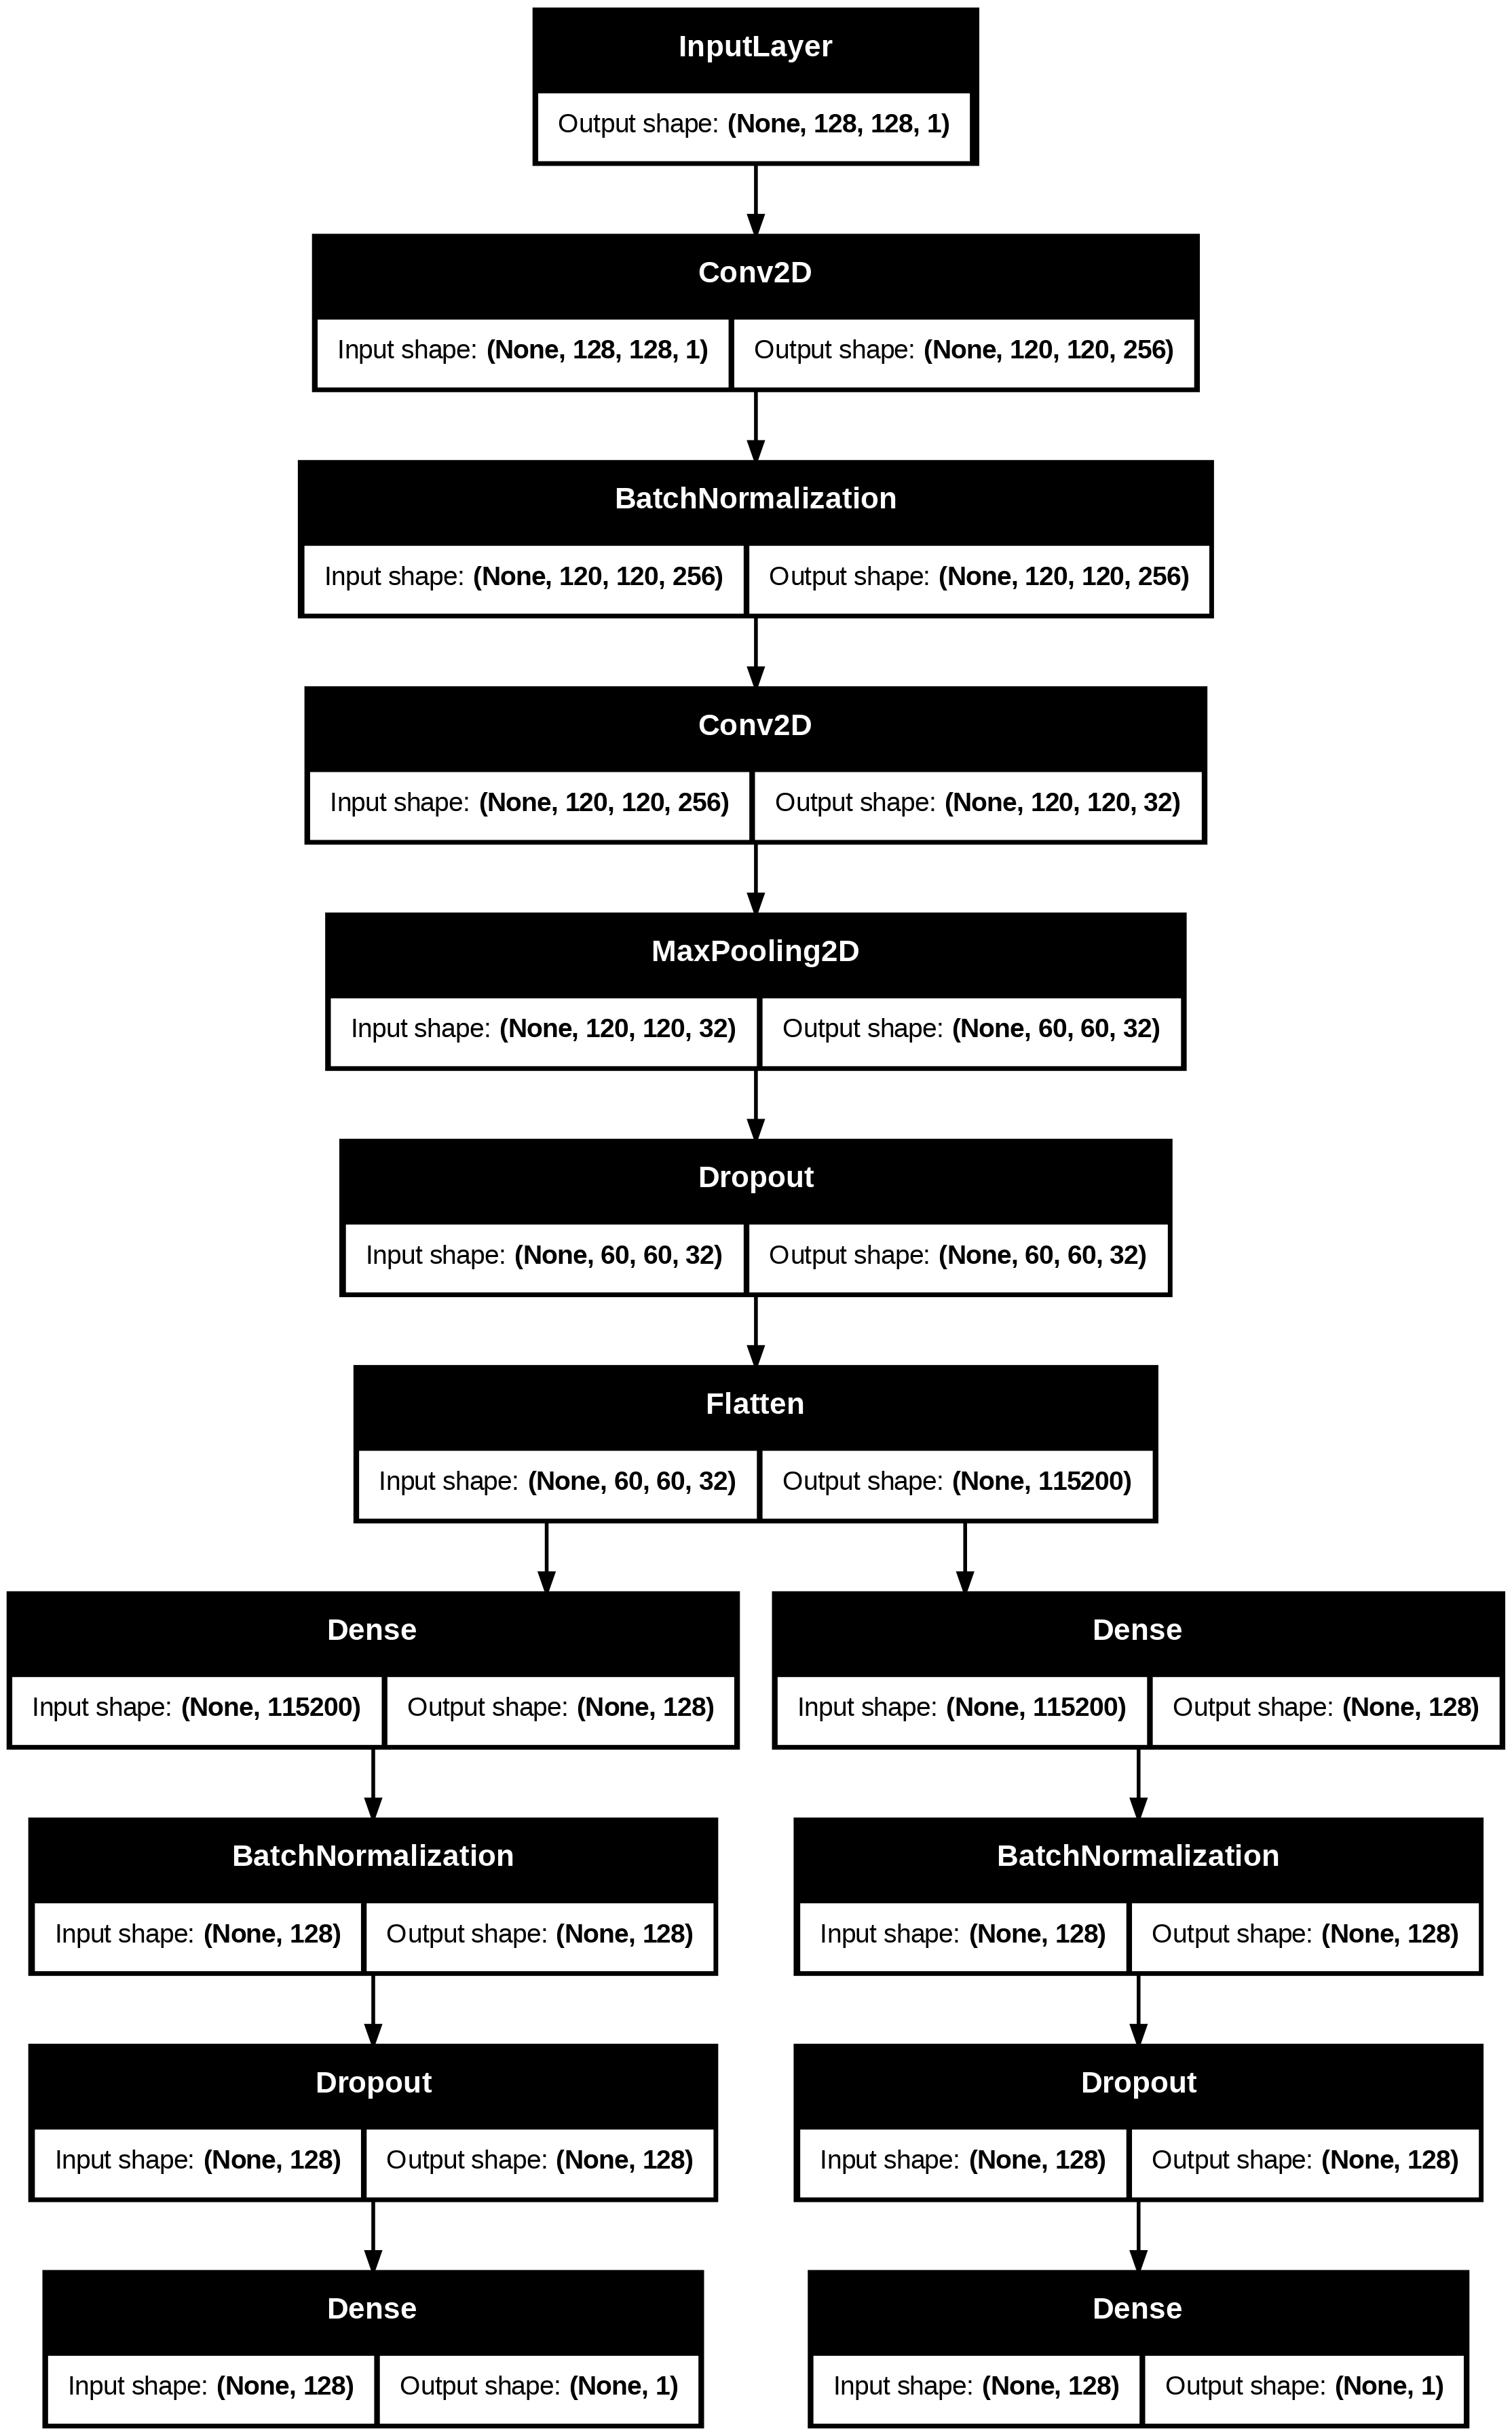

In [40]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, rankdir='TB')  # Save visualization to a file

# **6-Plot the Results**

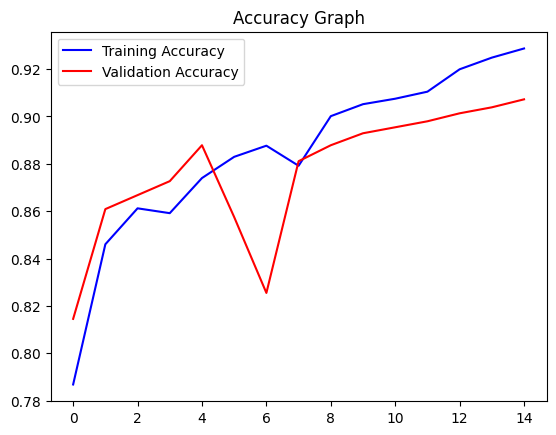

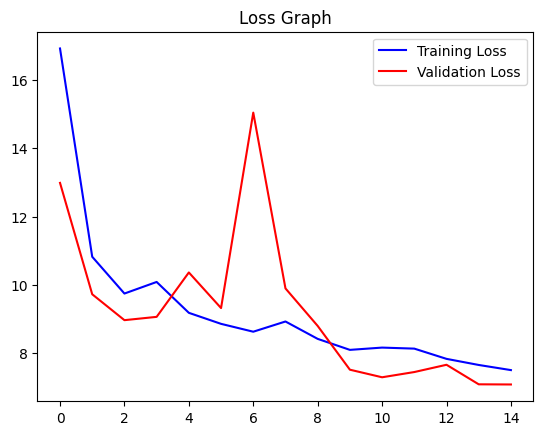

In [41]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## **Plot results for age**

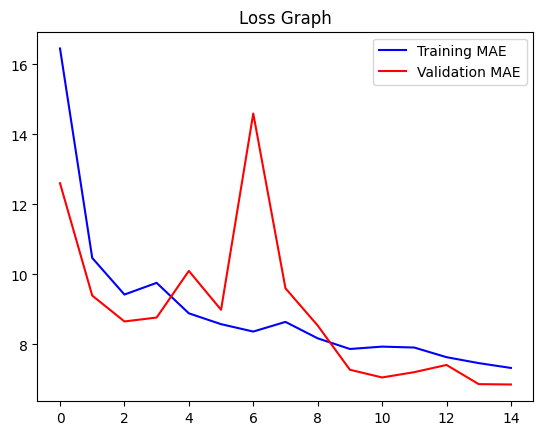

In [42]:
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

# **7-Prediction with Test Data**

Original Gender: Female Original Age: 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Gender: Female Predicted Age: 30


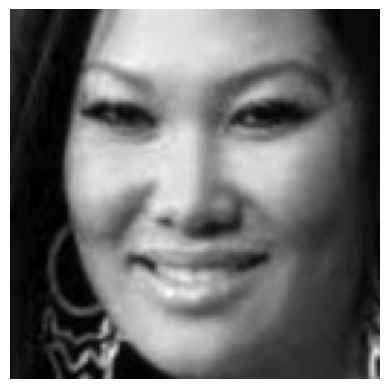

In [43]:
image_index = 50
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Gender: Male Predicted Age: 29


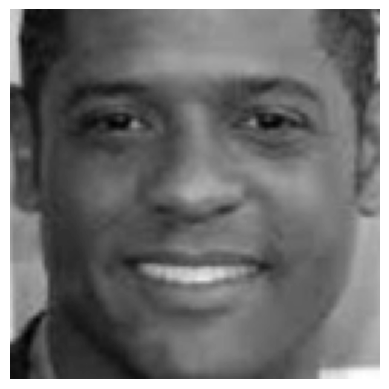

In [44]:
image_index = 500
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

## **Save Model**

In [46]:
model.save("/content/working/Gender_and_Age.h5")
model.save("/content/working/Gender_and_Age.keras")